In [1]:
! kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 92% 137M/149M [00:01<00:00, 123MB/s]
100% 149M/149M [00:01<00:00, 120MB/s]


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def get_class_paths(path):

    classes = []
    class_paths = []

    for label in os.listdir(path):

        label_path = os.path.join(path, label)

        if os.path.isdir(label_path):

            for image in os.listdir(label_path):

                image_path = os.path.join(label_path, image)

                classes.append(label)
                class_paths.append(image_path)

    df = pd.DataFrame({
        "Class Path": class_paths,
        "Class": classes
    })

    return df

In [4]:
tr_df = get_class_paths("/content/Training")
tr_df

,Class Path,Class
0,/content/Training/notumor/Tr-no_1219.jpg,notumor
1,/content/Training/notumor/Tr-no_1253.jpg,notumor
2,/content/Training/notumor/Tr-no_0647.jpg,notumor
3,/content/Training/notumor/Tr-no_0082.jpg,notumor
4,/content/Training/notumor/Tr-no_1039.jpg,notumor
...,...,...
5707,/content/Training/glioma/Tr-gl_0626.jpg,glioma
5708,/content/Training/glioma/Tr-gl_1176.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0434.jpg,glioma
5710,/content/Training/glioma/Tr-gl_0796.jpg,glioma


In [5]:
ts_df = get_class_paths("/content/Testing")
ts_df

,Class Path,Class
0,/content/Testing/notumor/Te-no_0084.jpg,notumor
1,/content/Testing/notumor/Te-no_0177.jpg,notumor
2,/content/Testing/notumor/Te-no_0287.jpg,notumor
3,/content/Testing/notumor/Te-no_0195.jpg,notumor
4,/content/Testing/notumor/Te-no_0114.jpg,notumor
...,...,...
1306,/content/Testing/glioma/Te-gl_0027.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0025.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0154.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0119.jpg,glioma


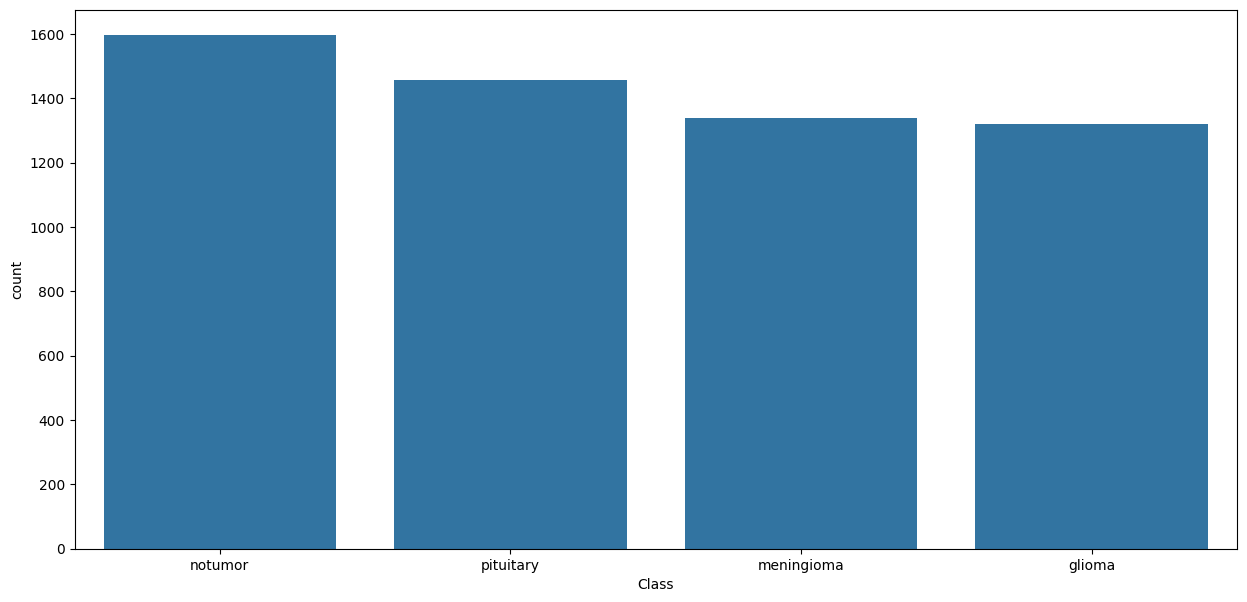

In [6]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=tr_df, x=tr_df["Class"])

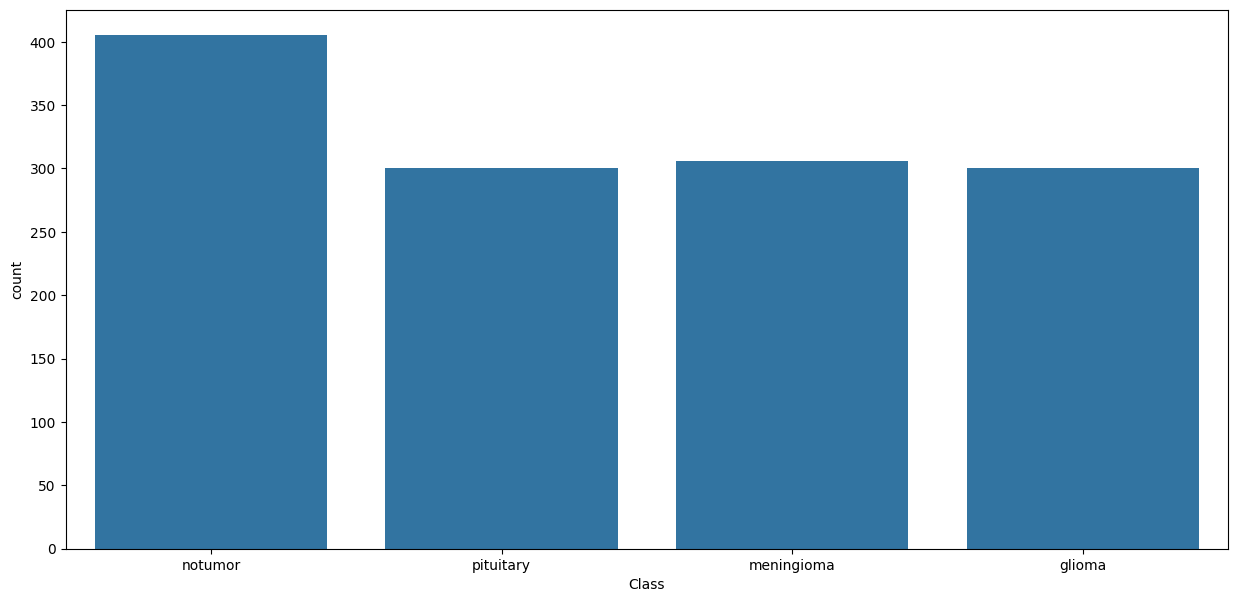

In [7]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=ts_df, x=ts_df["Class"])

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
valid_df, ts_df = train_test_split(ts_df, test_size=0.5, stratify=ts_df["Class"])

In [10]:
valid_df


,Class Path,Class
1003,/content/Testing/meningioma/Te-me_0012.jpg,meningioma
792,/content/Testing/meningioma/Te-me_0192.jpg,meningioma
480,/content/Testing/pituitary/Te-pi_0245.jpg,pituitary
781,/content/Testing/meningioma/Te-me_0092.jpg,meningioma
431,/content/Testing/pituitary/Te-pi_0262.jpg,pituitary
...,...,...
552,/content/Testing/pituitary/Te-pi_0230.jpg,pituitary
465,/content/Testing/pituitary/Te-pi_0129.jpg,pituitary
1143,/content/Testing/glioma/Te-gl_0163.jpg,glioma
948,/content/Testing/meningioma/Te-me_0122.jpg,meningioma


In [11]:
ts_df

,Class Path,Class
456,/content/Testing/pituitary/Te-pi_0108.jpg,pituitary
33,/content/Testing/notumor/Te-no_0133.jpg,notumor
454,/content/Testing/pituitary/Te-pi_0294.jpg,pituitary
798,/content/Testing/meningioma/Te-me_0298.jpg,meningioma
1214,/content/Testing/glioma/Te-gl_0127.jpg,glioma
...,...,...
712,/content/Testing/meningioma/Te-me_0249.jpg,meningioma
646,/content/Testing/pituitary/Te-pi_0133.jpg,pituitary
1013,/content/Testing/glioma/Te-gl_0221.jpg,glioma
1080,/content/Testing/glioma/Te-gl_0285.jpg,glioma


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
batch_size = 32

image_size = (299, 299)

image_generator = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8, 1.2)
)

ts_gen = ImageDataGenerator(rescale=1/255)

In [14]:
tr_gen = image_generator.flow_from_dataframe(
    tr_df,
    x_col="Class Path",
    y_col="Class",
    batch_size=batch_size,
    target_size=image_size
)

valid_gen = image_generator.flow_from_dataframe(
    valid_df,
    x_col="Class Path",
    y_col="Class",
    batch_size=batch_size,
    target_size=image_size
)

ts_gen = ts_gen.flow_from_dataframe(
    ts_df,
    x_col="Class Path",
    y_col="Class",
    batch_size=16,
    target_size=image_size,
    shuffle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


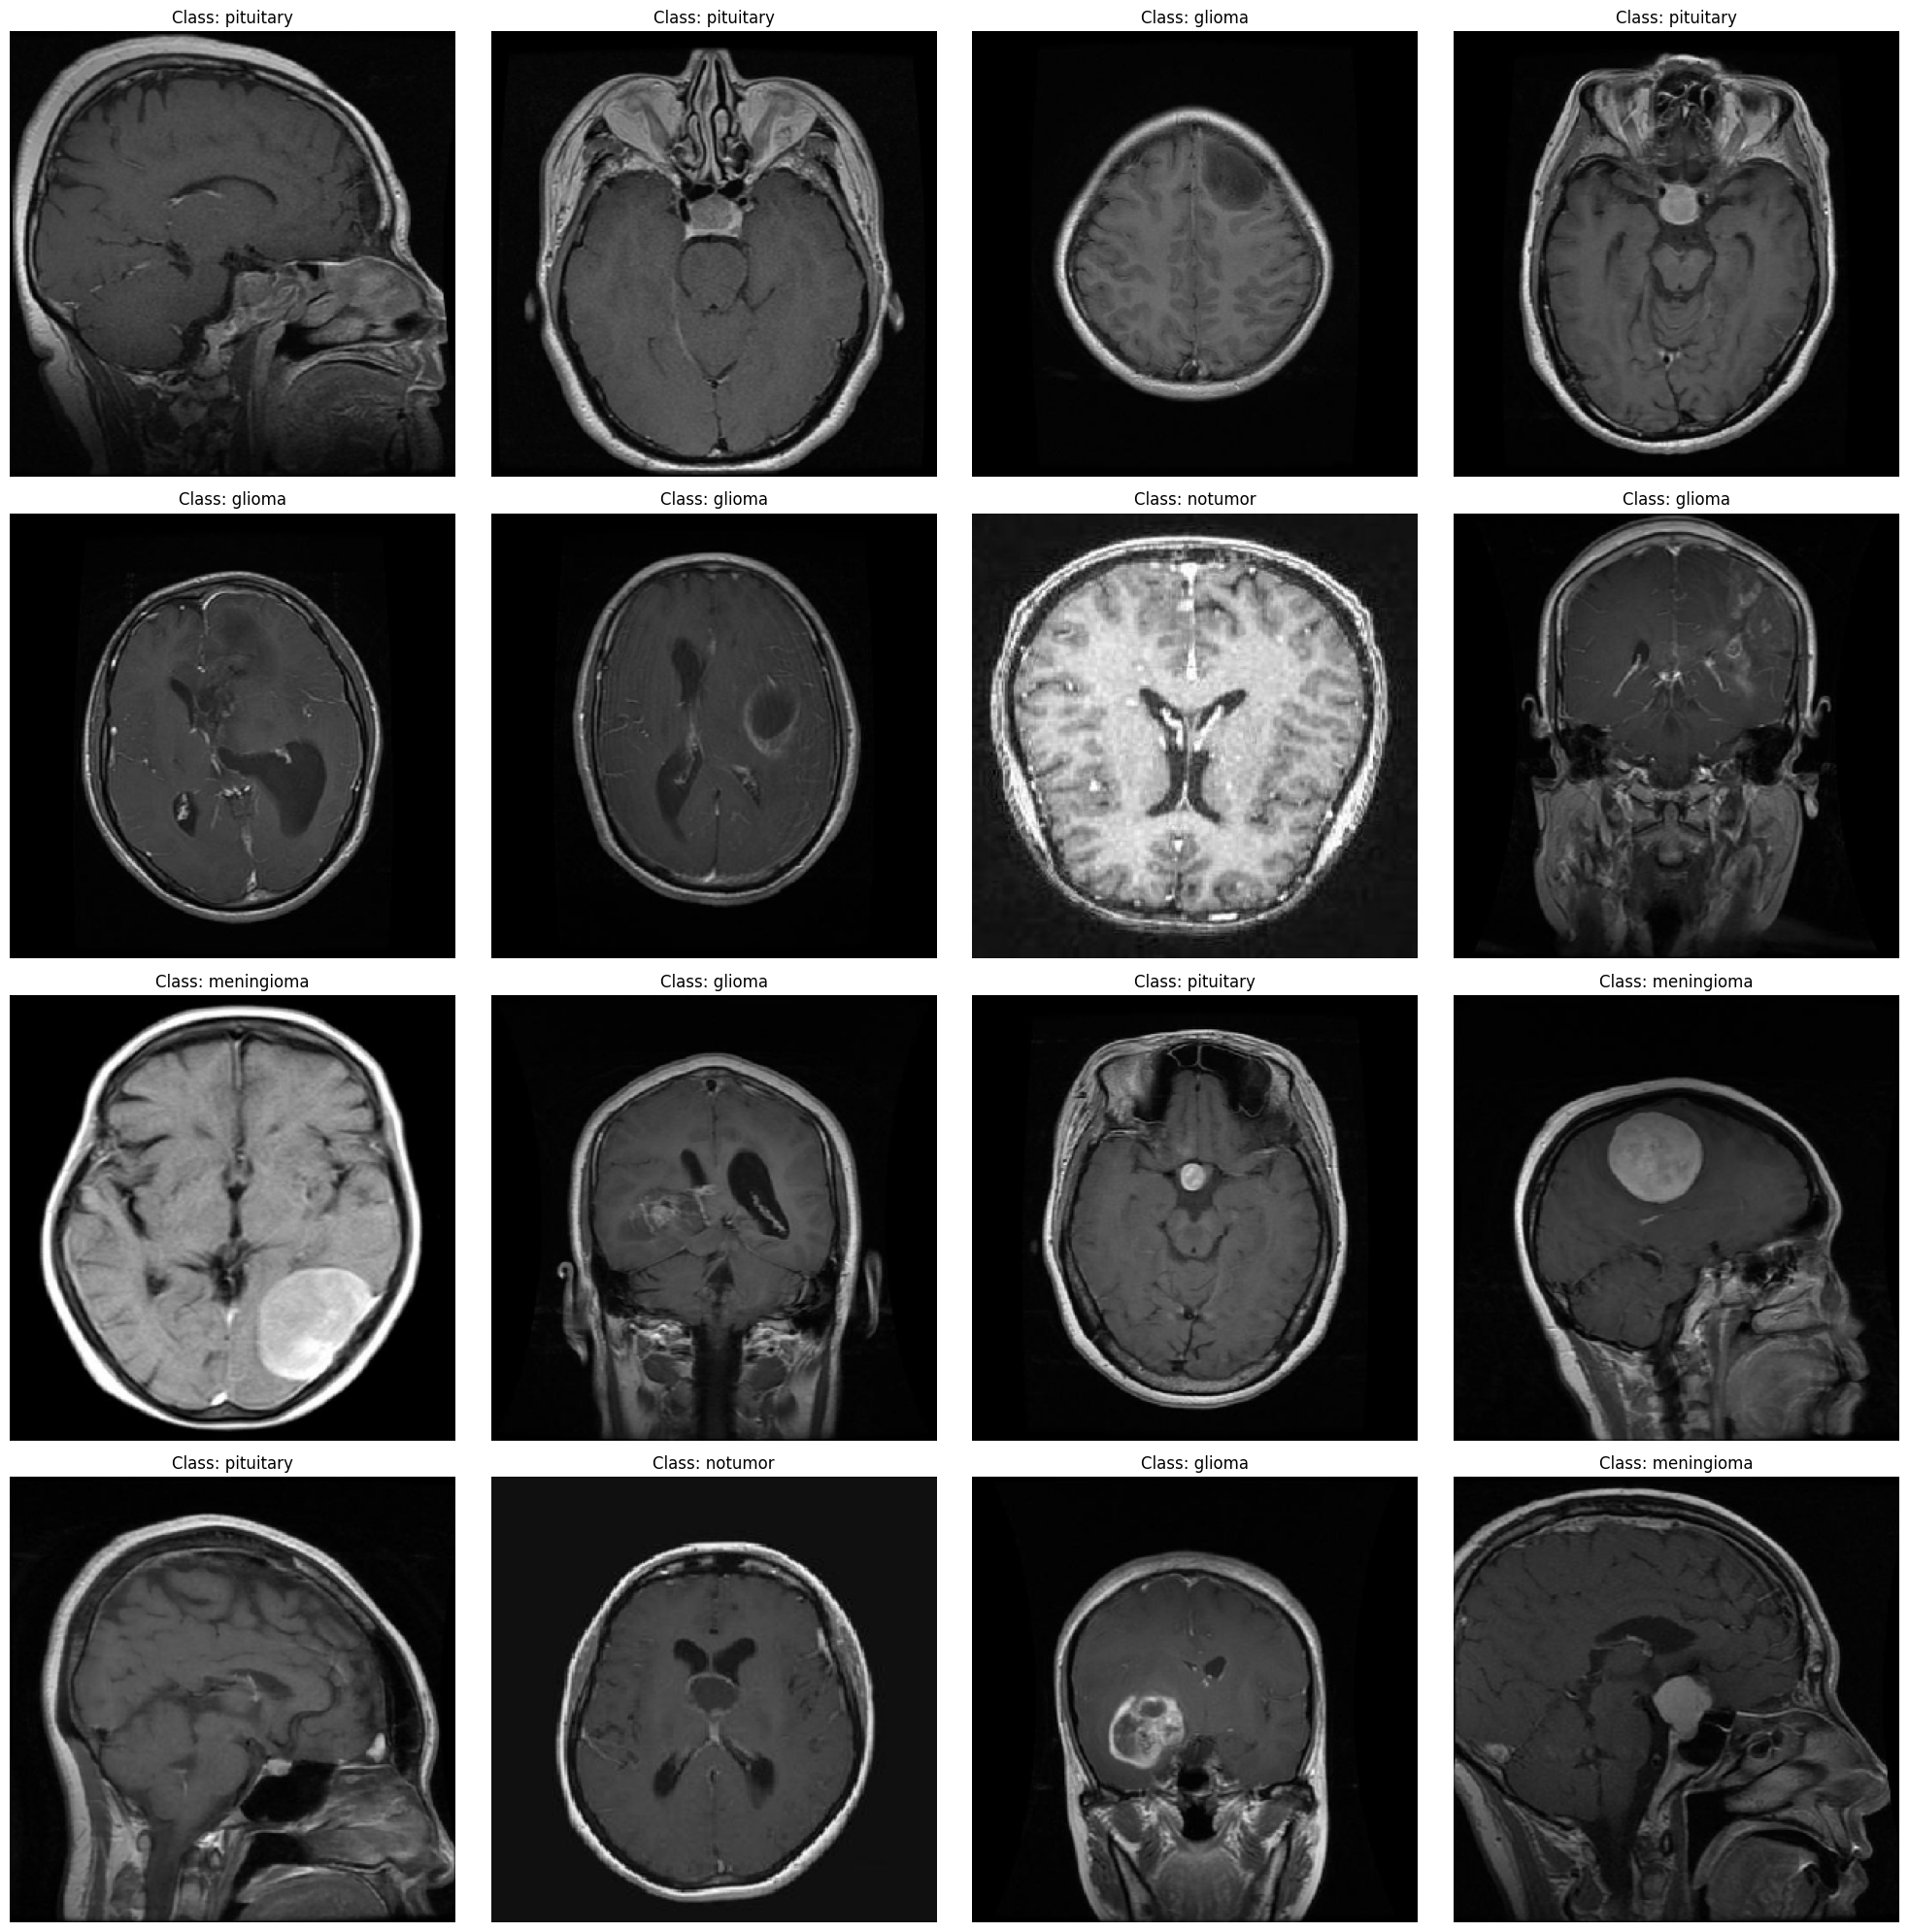

In [15]:
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    batch = next(ts_gen)
    image = batch[0][0]
    label = batch[1][0]
    plt.imshow(image)

    class_index = np.argmax(label)
    class_names = list(tr_gen.class_indices.keys())
    class_indices = list(tr_gen.class_indices.values())

    index_position = class_indices.index(class_index)
    class_name = class_names[index_position]

    plt.title(f"Class: {class_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [17]:
img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling="max"
)

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation="relu"),
    Dropout(rate=0.25),
    Dense(4, activation="softmax")
])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall

In [19]:
model.compile(Adamax(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=[
                  "accuracy",
                  Precision(),
                  Recall()
              ])

In [20]:
hist = model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.7484 - loss: 0.7141 - precision: 0.8260 - recall: 0.6372 - val_accuracy: 0.8427 - val_loss: 0.4277 - val_precision: 0.8498 - val_recall: 0.8382
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 216s 889ms/step - accuracy: 0.9821 - loss: 0.0582 - precision: 0.9832 - recall: 0.9819 - val_accuracy: 0.9466 - val_loss: 0.1542 - val_precision: 0.9508 - val_recall: 0.9450
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 201s 883ms/step - accuracy: 0.9900 - loss: 0.0309 - precision: 0.9910 - recall: 0.9899 - val_accuracy: 0.9847 - val_loss: 0.0343 - val_precision: 0.9847 - val_recall: 0.9817
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 158s 877ms/step - accuracy: 0.9929 - loss: 0.0230 - precision: 0.9929 - recall: 0.9923 - val_accuracy: 0.9908 - val_loss: 0.0251 - val_precision: 0.9908 - val_recall: 0.9908
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 160s 884ms/step - accuracy: 0.9970 - loss: 0.0085 - precision: 0.9975 - recall: 0.9969 - val_accuracy: 0.9908 - val_loss: 

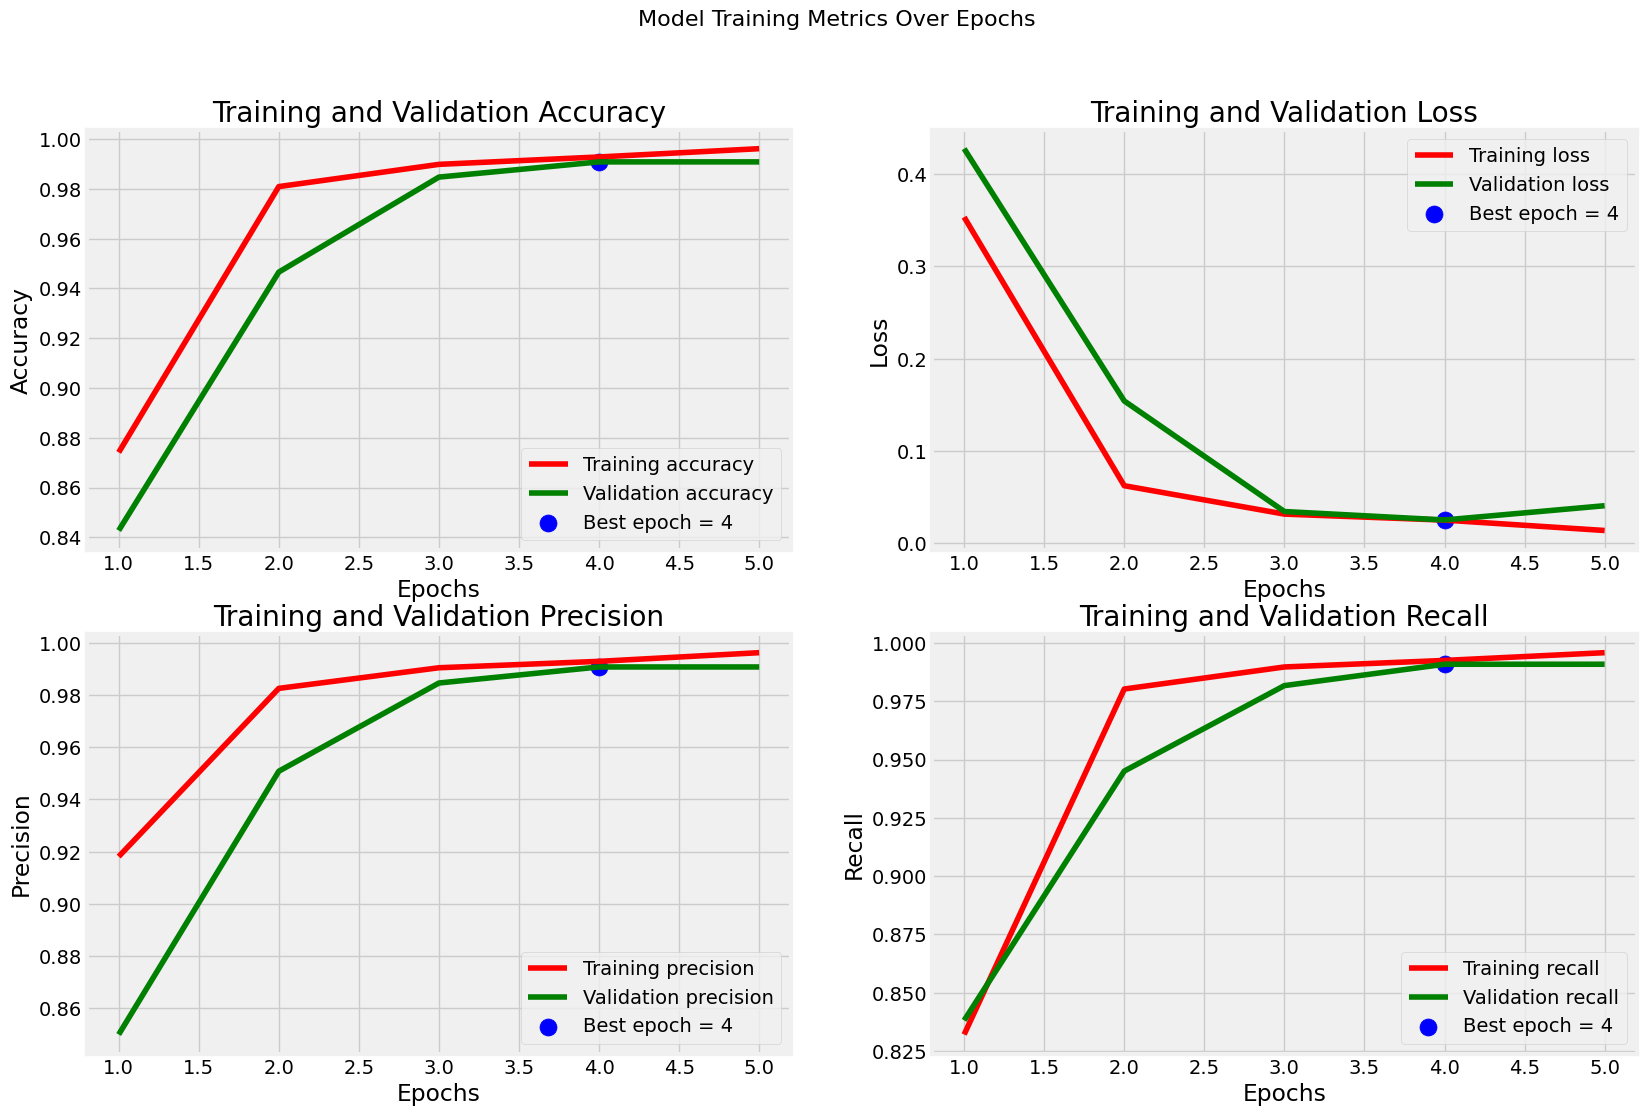

In [21]:
metrics = ["accuracy", "loss", "precision", "recall"]
tr_metrics = { m: hist.history[m] for m in metrics }
val_metrics = { m: hist.history[f"val_{m}"] for m in metrics }

best_epochs = {}
best_values = {}
for m in metrics:
  if m == "loss":
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]

plt.figure(figsize=(20, 12))
plt.style.use("fivethirtyeight")

for i, metric in enumerate(metrics, 1):
  plt.subplot(2, 2, i)
  epochs = range(1, len(tr_metrics[metric]) + 1)

  plt.plot(epochs, tr_metrics[metric], "r", label=f"Training {metric}")
  plt.plot(epochs, val_metrics[metric], "g", label=f"Validation {metric}")
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c="blue", label=f"Best epoch = {best_epochs[metric]}")

  plt.title(f"Training and Validation {metric.title()}")
  plt.xlabel("Epochs")
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle("Model Training Metrics Over Epochs", fontsize=16)
plt.show()

In [22]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Accuracy: {train_score[1] * 100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1] * 100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1] * 100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 48s 268ms/step - accuracy: 0.9974 - loss: 0.0077 - precision: 0.9977 - recall: 0.9974
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.9894 - loss: 0.0420 - precision: 0.9894 - recall: 0.9894
 1/41 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.9375 - loss: 0.2287 - precision: 0.9375 - recall: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9827 - loss: 0.0810 - precision: 0.9827 - recall: 0.9827
Train Accuracy: 99.72%
Train Loss: 0.0086


Validation Accuracy: 98.93%
Validation Loss: 0.0431


Test Accuracy: 98.48%
Test Loss: 0.0673


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step


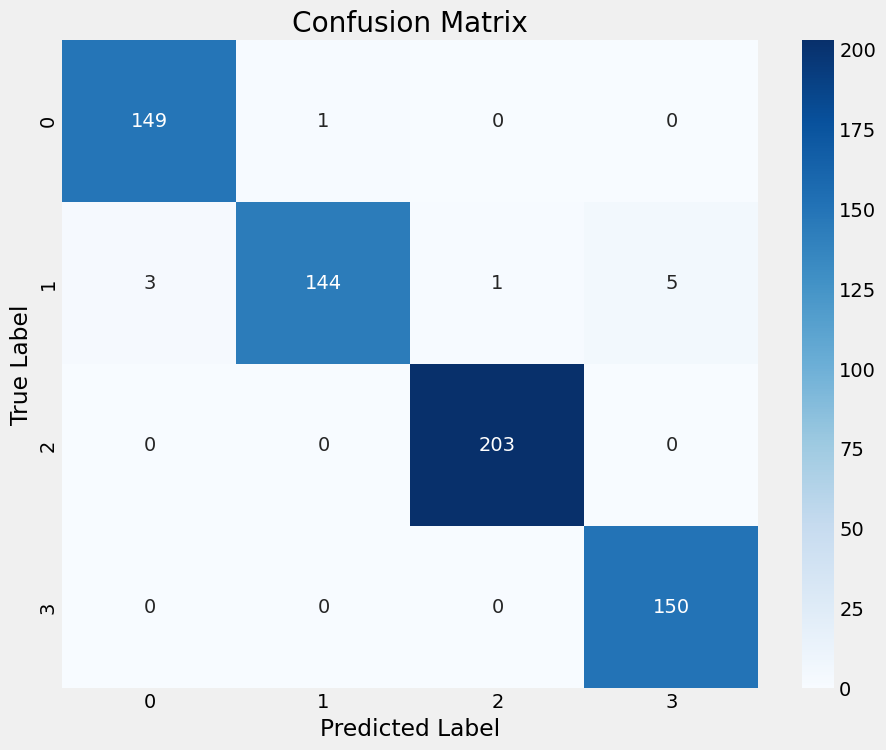

In [23]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: "glioma",
    1: "meningioma",
    2: "no_tumor",
    3: "pituitary"
}

cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [24]:
from PIL import Image

def predict(img_path):

  labels = list(class_dict.keys())

  plt.figure(figsize=(6, 8))

  img = Image.open(img_path)
  resized_img = img.resize((299, 299))
  img_array = np.array(resized_img)
  img_array = np.expand_dims(img_array, axis=0) / 255.0

  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.title(f"Input MRI Image\nPredicted: {predicted_class}")

  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel("Probability", fontsize=15)
  plt.title("Class Probabilities")

  ax = plt.gca()
  ax.bar_label(bars, fmt="%.2f")

  plt.tight_layout()
  plt.show()

  print(f"\nPredicted tumor type: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


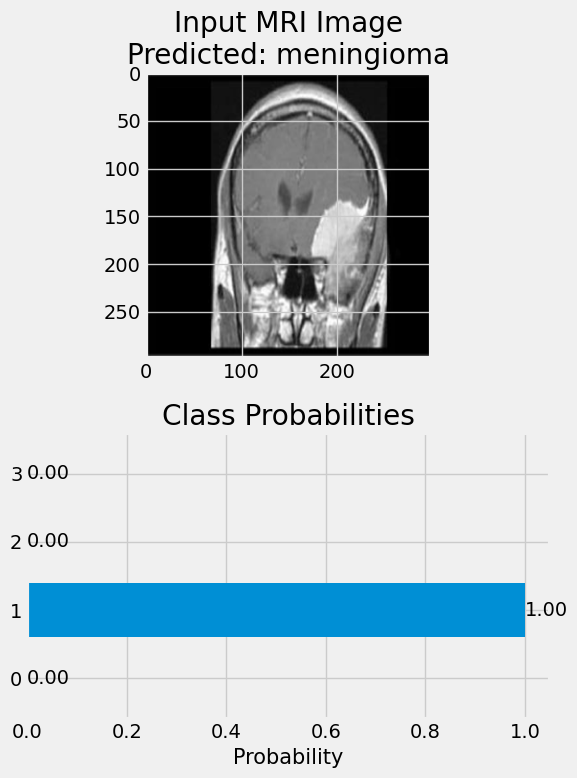


Predicted tumor type: meningioma


In [25]:
predict("/content/Testing/meningioma/Te-meTr_0000.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


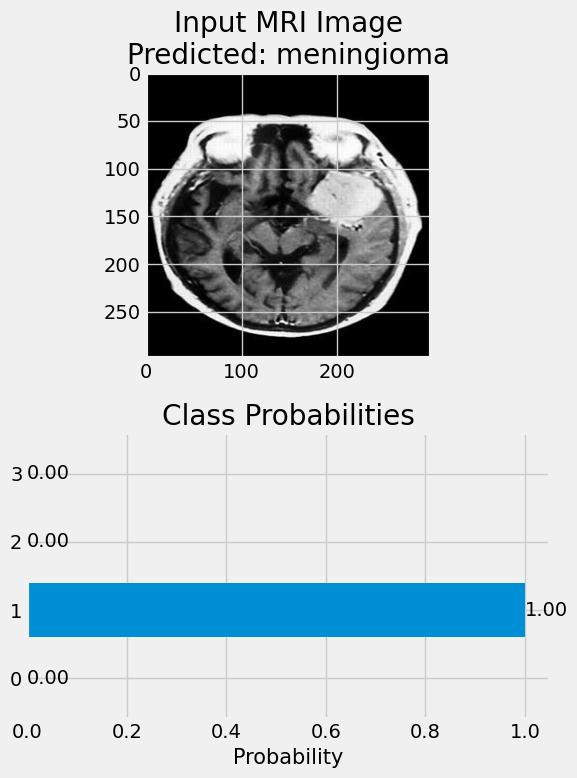


Predicted tumor type: meningioma


In [26]:
predict("/content/Testing/meningioma/Te-meTr_0005.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


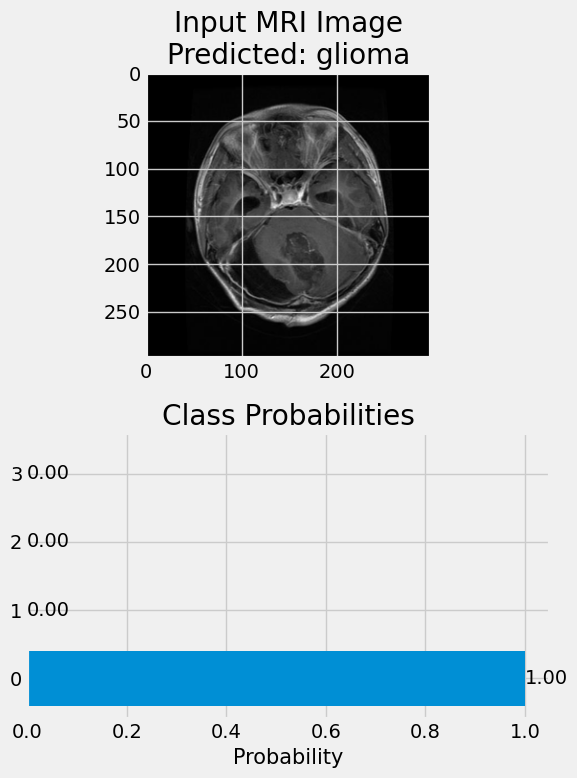


Predicted tumor type: glioma


In [27]:
predict("/content/Testing/glioma/Te-glTr_0000.jpg")

In [45]:
model.save_weights("xception_model.weights.h5")

# Custom CNN

In [29]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [30]:
batch_size = 16

image_size = (224, 224)

image_generator = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8, 1.2)
)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = image_generator.flow_from_dataframe(
    tr_df,
    x_col="Class Path",
    y_col="Class",
    batch_size=batch_size,
    target_size=image_size
)

valid_gen = image_generator.flow_from_dataframe(
    valid_df,
    x_col="Class Path",
    y_col="Class",
    batch_size=batch_size,
    target_size=image_size
)

ts_gen = ts_gen.flow_from_dataframe(
    ts_df,
    x_col="Class Path",
    y_col="Class",
    batch_size=16,
    target_size=image_size,
    shuffle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [31]:
cnn_model = Sequential()

# Convolutional layers
cnn_model.add(Conv2D(512, (3, 3), padding="same", input_shape=(224, 224, 3), activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for fully connected layers
cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

# Output layer with 4 neurons for the 4 classes
cnn_model.add(Dense(4, activation="softmax"))

# Compile model
cnn_model.compile(Adamax(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy", Precision(), Recall()])

# Display the model summary
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,775,620 (18.22 MB)

 Trainable params: 4,775,620 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = cnn_model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 155s 354ms/step - accuracy: 0.5678 - loss: 2.3349 - precision_1: 0.6908 - recall_1: 0.3935 - val_accuracy: 0.7313 - val_loss: 0.9522 - val_precision_1: 0.7712 - val_recall_1: 0.6794
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 107s 298ms/step - accuracy: 0.8074 - loss: 0.7711 - precision_1: 0.8245 - recall_1: 0.7648 - val_accuracy: 0.8092 - val_loss: 0.6551 - val_precision_1: 0.8390 - val_recall_1: 0.7481
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 299ms/step - accuracy: 0.8543 - loss: 0.5492 - precision_1: 0.8661 - recall_1: 0.8351 - val_accuracy: 0.8382 - val_loss: 0.5161 - val_precision_1: 0.8502 - val_recall_1: 0.8229
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 107s 300ms/step - accuracy: 0.8852 - loss: 0.4428 - precision_1: 0.8960 - recall_1: 0.8720 - val_accuracy: 0.8702 - val_loss: 0.4251 - val_precision_1: 0.8928 - val_recall_1: 0.8519
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 300ms/step - accuracy: 0.9137 - loss: 0.3660 - precision_1: 0.9174 - recall_1: 0.9

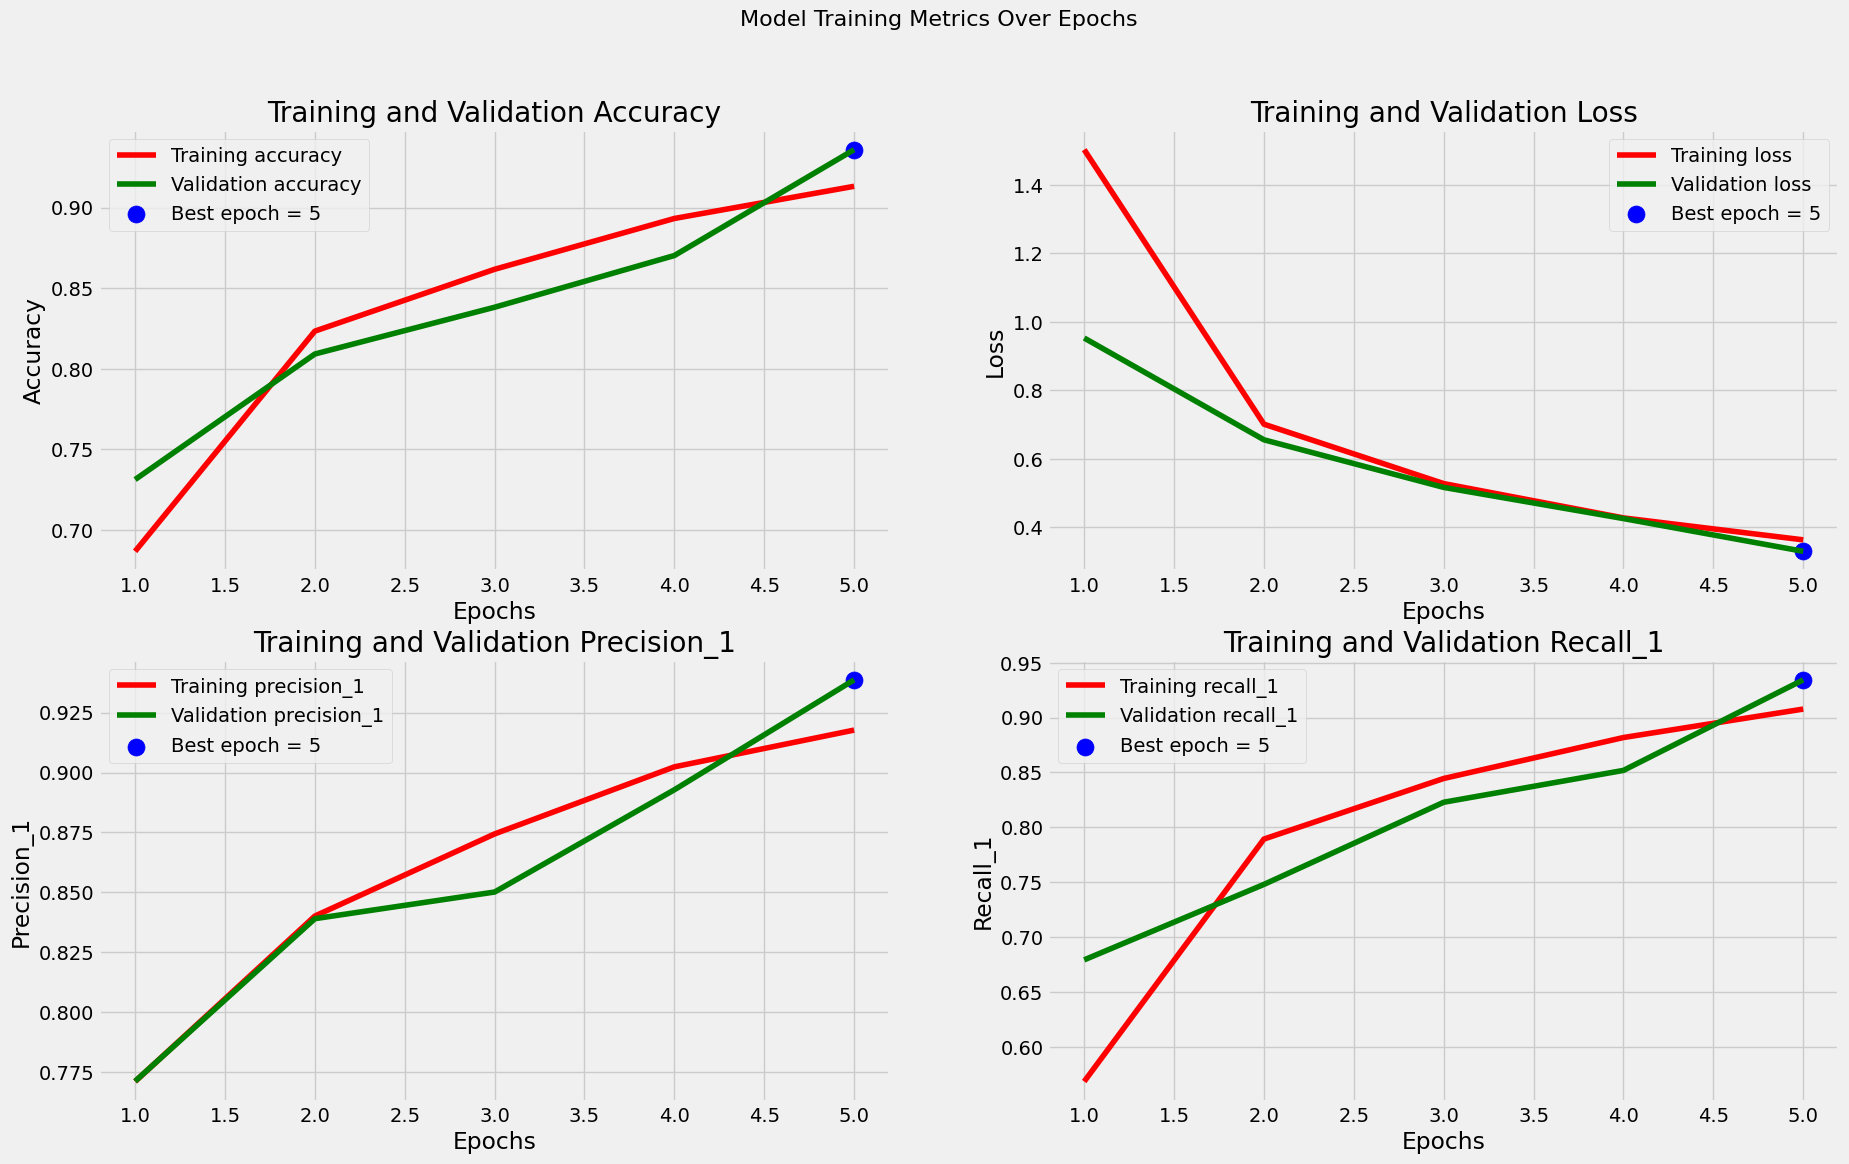

In [38]:
metrics = ["accuracy", "loss", "precision_1", "recall_1"]
tr_metrics = { m: history.history[m] for m in metrics }
val_metrics = { m: history.history[f"val_{m}"] for m in metrics }

best_epochs = {}
best_values = {}
for m in metrics:
  if m == "loss":
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]

plt.figure(figsize=(20, 12))
plt.style.use("fivethirtyeight")

for i, metric in enumerate(metrics, 1):
  plt.subplot(2, 2, i)
  epochs = range(1, len(tr_metrics[metric]) + 1)

  plt.plot(epochs, tr_metrics[metric], "r", label=f"Training {metric}")
  plt.plot(epochs, val_metrics[metric], "g", label=f"Validation {metric}")
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c="blue", label=f"Best epoch = {best_epochs[metric]}")

  plt.title(f"Training and Validation {metric.title()}")
  plt.xlabel("Epochs")
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)

plt.suptitle("Model Training Metrics Over Epochs", fontsize=16)
plt.show()

In [39]:
train_score = cnn_model.evaluate(tr_gen, verbose=1)
valid_score = cnn_model.evaluate(valid_gen, verbose=1)
test_score = cnn_model.evaluate(ts_gen, verbose=1)

print(f"Train Accuracy: {train_score[1] * 100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1] * 100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1] * 100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.9544 - loss: 0.2658 - precision_1: 0.9581 - recall_1: 0.9505
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9394 - loss: 0.3171 - precision_1: 0.9442 - recall_1: 0.9391
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9320 - loss: 0.3426 - precision_1: 0.9405 - recall_1: 0.9203
Train Accuracy: 96.13%
Train Loss: 0.2600


Validation Accuracy: 93.74%
Validation Loss: 0.3258


Test Accuracy: 92.07%
Test Loss: 0.3580


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step


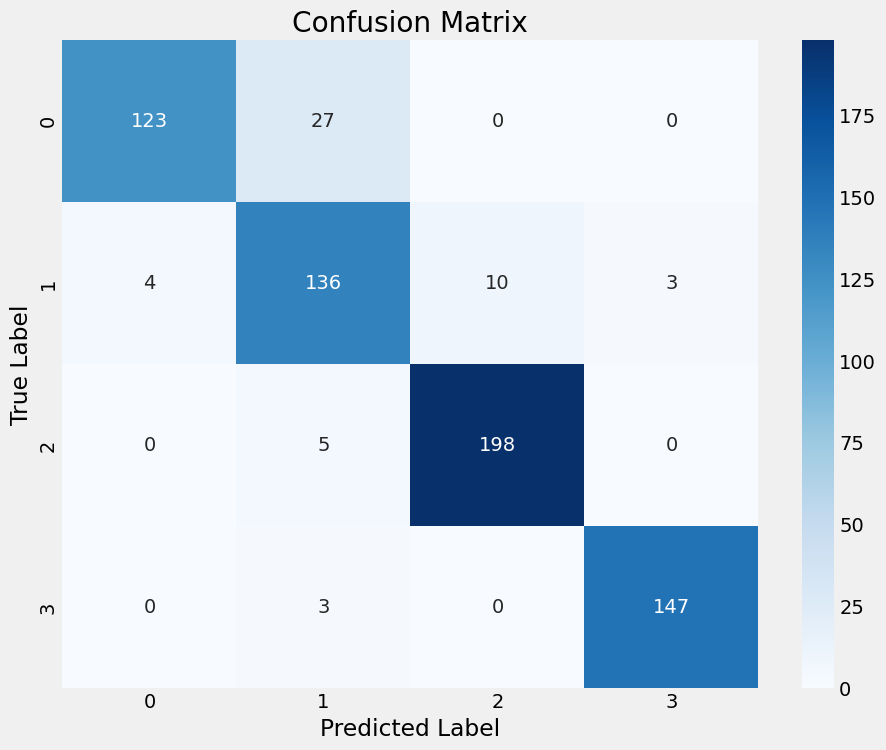

In [41]:
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: "glioma",
    1: "meningioma",
    2: "no_tumor",
    3: "pituitary"
}

cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [43]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       150
           1       0.80      0.89      0.84       153
           2       0.95      0.98      0.96       203
           3       0.98      0.98      0.98       150

    accuracy                           0.92       656
   macro avg       0.92      0.92      0.92       656
weighted avg       0.93      0.92      0.92       656



In [46]:
cnn_model.save_weights("cnn_model.weights.h5")